In [89]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
import tqdm
from collections import deque
from random import sample
import numpy as np
import matplotlib.pyplot as plt

In [90]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [91]:
env = gym.make('LunarLander-v2')
obs_space = env.observation_space.shape[0]
act_space = env.action_space.n

In [92]:
MAX_STEPS = 1000
EPSILON_EXP = 0.99
EPSILON_LIN = 0.01

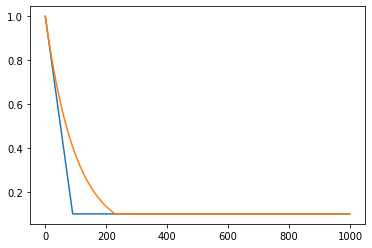

In [93]:
exp_epsilons = [max(0.1, 1 * EPSILON_EXP**i) for i in range(MAX_STEPS)]
lin_epsilons = [max(0.1, 1 - EPSILON_LIN * i) for i in range(MAX_STEPS)]
    
plt.plot(lin_epsilons)
plt.plot(exp_epsilons)

In [96]:
a = deque(maxlen=100)
for i in range(50):
    a.append(i)

indicies = sample(range(len(a)), 10)
[a[i] for i in indicies]

[24, 44, 29, 49, 15, 0, 36, 45, 21, 9]

In [123]:
class ReplayBuffer():
    def __init__(self, length, device):
        self.length = length
        self.device = device
        self.observations = deque(maxlen=length)
        self.actions = deque(maxlen=length)
        self.rewards = deque(maxlen=length)
        self.dones = deque(maxlen=length)
        self.next_observations = deque(maxlen=length)
        self.next_actions = deque(maxlen=length)
        
    def add_experience(self, obs, reward, action, done, next_obs, next_action):
        self.observations.append(torch.from_numpy(obs).to(self.device))
        self.actions.append(torch.tensor(action).to(device))
        self.rewards.append(torch.tensor(reward).to(device))
        self.dones.append(torch.tensor(done).to(device))
        self.next_observations.append(torch.from_numpy(next_obs).to(self.device))
        self.next_actions.append(torch.tensor(next_action).to(device))
        
    def sample_experience(self, size):
        indicies = sample(range(len(self.observations)), size)
        sampled_observations = torch.stack([self.observations[i] for i in indicies])
        sampled_actions = torch.stack([self.actions[i] for i in indicies])
        sampled_rewards = torch.stack([self.rewards[i] for i in indicies])
        sampled_dones = torch.stack([self.dones[i] for i in indicies])
        sampled_next_observations = torch.stack([self.next_observations[i] for i in indicies])
        sampled_next_actions = torch.stack([self.next_actions[i] for i in indicies])
        return sampled_observations, sampled_actions, sampled_rewards, sampled_dones, sampled_next_observations, sampled_next_actions

In [124]:
class DQN(nn.Module):
    def __init__(self, obs_space, act_space, device):
        super(DQN, self).__init__()
        self.obs_space = obs_space
        self.act_space = act_space
        self.device = device
        
        self.backbone = nn.Sequential(
            nn.Linear(self.obs_space, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, self.act_space),
        ).to(self.device)
        

    def forward(self, x):
        x = torch.from_numpy(x).to(self.device)
        logits = self.backbone(x)
        return logits
    
    def get_action(self, obs, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(self.act_space)
        else:
            logits = self.forward(obs)
            dist = Categorical(logits=logits)
            return dist.sample().item()
            
            

In [125]:
dqn = DQN(obs_space, act_space, device)
buffer = ReplayBuffer(1000000, device)

In [132]:
obs = env.reset()
action = dqn.get_action(obs, exp_epsilons[0])
done = False
reward = 0
for step in range(MAX_STEPS):
    next_obs, reward, done, _ = env.step(action)
    next_action = dqn.get_action(next_obs, exp_epsilons[step])
    buffer.add_experience(obs, reward, action, done, next_obs, next_action)
    obs = next_obs
    action = next_action
    if done:
        obs = env.reset()
        done = False
        reward = 0
        

In [133]:
a, b, c, d, e, f = buffer.sample_experience(10)

In [134]:
print(a.shape, b.shape, c.shape, d.shape, e.shape, f.shape)

torch.Size([10, 8]) torch.Size([10]) torch.Size([10]) torch.Size([10]) torch.Size([10, 8]) torch.Size([10])
